In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

<Axes: xlabel='timestamp'>

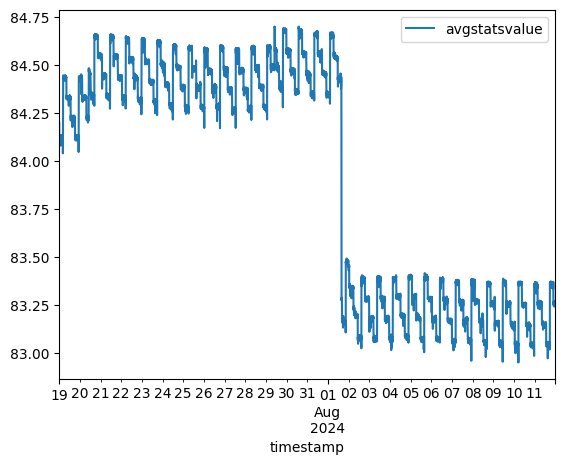

In [35]:
# data with 5 minutes interval
df1 = pd.read_csv(Path('./data/hlwzt78_task').joinpath(
    f"xlwzt78/key5_20240719_20240811划分ip/9.198.176.214.csv"), parse_dates=['timestamp'])

# sample the first two weeks
# df = df[df['timestamp'] >= '2024-07-22']
# df = df[df['timestamp'] < '2024-08-05']
df1.plot(x='timestamp', y='avgstatsvalue')

<Axes: xlabel='timestamp'>

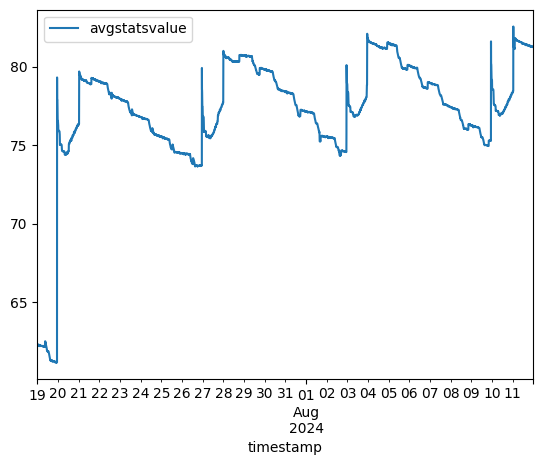

In [26]:
# data with 5 minutes interval
df2 = pd.read_csv(Path('./data/hlwzt78_task').joinpath(
    f"xlwzt78/key5_20240719_20240811划分ip/9.198.182.214.csv"), parse_dates=['timestamp'], index_col='timestamp')

# sample the first two weeks
# df = df[df['timestamp'] >= '2024-07-22']
# df = df[df['timestamp'] < '2024-08-05']
df2.plot(y='avgstatsvalue')

In [2]:
data = pd.DataFrame()

ips = [f.stem for f in Path('./data/poc').glob(f"*.csv")]
for ip in ips:
    df = pd.read_csv(Path('./data/poc').joinpath(
        f"{ip}.csv"), parse_dates=['timestamp'])
    data = pd.concat([data, df])

In [3]:
# check invalid timestamp in the data, trying to parse the timestamp
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')

# show the invalid timestamp and remove them
invalid_timestamp = data['timestamp'].isnull()
print(data[invalid_timestamp])
data = data[~invalid_timestamp]

# Add time features (hour of day, day of week)
data['hour'] = data['timestamp'].dt.hour
data['day_of_week'] = data['timestamp'].dt.dayofweek

# # One-hot encode IP addresses (or you can use embedding later)
# ip_address_onehot = pd.get_dummies(data['ip'], prefix='ip')
# data = pd.concat([data, ip_address_onehot], axis=1)

# # Convert IP addresses to indices
# ip_address_to_idx = {ip: idx for idx,
#                      ip in enumerate(data['ip'].unique())}
# data['ip_index'] = data['ip'].map(ip_address_to_idx)

# Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
data['avgstatsvalue'] = scaler.fit_transform(
    data[['avgstatsvalue']])

Empty DataFrame
Columns: [CCHR_TYPE1, CCHR_ROUTE1, key, ip, avgstatsvalue, maxstatsvalue, minstatsvalue, timestamp]
Index: []


In [4]:
data[['avgstatsvalue',
      'hour', 'day_of_week']]

,avgstatsvalue,hour,day_of_week
0,0.202869,0,4
1,0.202231,0,4
2,0.202326,0,4
3,0.202380,0,4
4,0.202425,0,4
...,...,...,...
6907,0.996213,23,6
6908,0.996158,23,6
6909,0.996027,23,6
6910,0.996003,23,6


In [5]:
# Prepare sequences
def create_sequences(data, time_steps=288):
    sequences = []
    labels = []
    for i in tqdm(range(time_steps, len(data))):
        sequence = data.iloc[i-time_steps:i][['avgstatsvalue',
                                              'hour', 'day_of_week']].values
        label = data.iloc[i][['avgstatsvalue']].values
        sequences.append((sequence))
        labels.append(label)
    return sequences, np.array(labels)


time_steps = 288  # One day worth of data
sequences, labels = create_sequences(data, time_steps)

100%|██████████| 34271/34271 [00:11<00:00, 3077.34it/s]


In [21]:
# Split sequences and IP indices
X = np.array(sequences)
y = labels.astype(np.float32)

ori_len = len(X)
X_train0 = X[:int(0.1*ori_len)]
y_train0 = y[:int(0.1*ori_len)]

# Split data into training and validation sets
split_index = int(0.8 * len(X_train0))
X_train, X_val = X_train0[:split_index], X_train0[split_index:]
y_train, y_val = y_train0[:split_index], y_train0[split_index:]

# Convert to PyTorch tensors
X_train = torch.Tensor(X_train).to(device)
y_train = torch.Tensor(y_train).to(device)

X_train.shape, y_train.shape

(torch.Size([2741, 288, 3]), torch.Size([2741, 1]))

In [22]:
# LSTM model with IP address embedding
class LSTMWithEmbedding(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMWithEmbedding, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size,
                            hidden_size, num_layers, batch_first=True)

        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(
            0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(
            0), self.hidden_size).to(x.device)

        # Forward propagate through LSTM
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Output from the last time step
        return out

In [23]:
# Hyperparameters
# Number of input features (memory, time features)
input_size = X_train.shape[2]
hidden_size = 64
output_size = 1  # Predicting memory usage
num_layers = 2
learning_rate = 0.001

# Initialize the model, loss function, and optimizer
model = LSTMWithEmbedding(input_size, hidden_size, output_size,
                          num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [24]:
# Training the model
num_epochs = 2000
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    rmse = torch.sqrt(loss)
    mape = torch.mean(torch.abs((y_train - outputs) / y_train)) * 100

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f} RMSE: {rmse:.4f}, MAPE: {mape:.4f}')

Epoch [100/2000], Loss: 0.0014 RMSE: 0.0378, MAPE: 13.8829
Epoch [200/2000], Loss: 0.0014 RMSE: 0.0369, MAPE: 13.5483
Epoch [300/2000], Loss: 0.0013 RMSE: 0.0360, MAPE: 14.1470
Epoch [400/2000], Loss: 0.0005 RMSE: 0.0233, MAPE: 8.6935
Epoch [500/2000], Loss: 0.0001 RMSE: 0.0088, MAPE: 2.1772
Epoch [600/2000], Loss: 0.0001 RMSE: 0.0083, MAPE: 1.7732
Epoch [700/2000], Loss: 0.0001 RMSE: 0.0080, MAPE: 1.6535
Epoch [800/2000], Loss: 0.0001 RMSE: 0.0078, MAPE: 1.5138
Epoch [900/2000], Loss: 0.0001 RMSE: 0.0088, MAPE: 2.4702
Epoch [1000/2000], Loss: 0.0001 RMSE: 0.0085, MAPE: 2.3889
Epoch [1100/2000], Loss: 0.0001 RMSE: 0.0077, MAPE: 1.4976
Epoch [1200/2000], Loss: 0.0001 RMSE: 0.0092, MAPE: 2.9633
Epoch [1300/2000], Loss: 0.0001 RMSE: 0.0076, MAPE: 1.5678
Epoch [1400/2000], Loss: 0.0000 RMSE: 0.0070, MAPE: 1.1857
Epoch [1500/2000], Loss: 0.0001 RMSE: 0.0076, MAPE: 1.6002
Epoch [1600/2000], Loss: 0.0001 RMSE: 0.0080, MAPE: 2.2607
Epoch [1700/2000], Loss: 0.0000 RMSE: 0.0069, MAPE: 1.4629
Epo

In [25]:
# Validation
model.eval()
with torch.no_grad():
    X_val = torch.Tensor(X_val).to(device)
    y_val = torch.Tensor(y_val).to(device)
    outputs = model(X_val)
    val_loss = criterion(outputs, y_val)

    # rmse
    val_rmse = torch.sqrt(val_loss)
    print(f'Validation RMSE: {val_rmse.item():.4f}')

    # mape
    val_mape = torch.mean(torch.abs((outputs - y_val) / y_val))
    print(f'Validation MAPE: {val_mape.item():.4f}')

    print(f'Validation loss: {val_loss.item():.4f}')

Validation RMSE: 0.0132
Validation MAPE: 0.0396
Validation loss: 0.0002


In [33]:
X_val1 = X[int(0.7*ori_len):int(0.8*ori_len)]
y_val1 = y[int(0.7*ori_len):int(0.8*ori_len)]

model.eval()
with torch.no_grad():
    X_val1 = torch.Tensor(X_val1).to(device)
    y_val1 = torch.Tensor(y_val1).to(device)
    outputs = model(X_val1)
    val_loss = criterion(outputs, y_val1)

    # rmse
    val_rmse = torch.sqrt(val_loss)
    print(f'Validation RMSE: {val_rmse.item():.4f}')

    # mape
    val_mape = torch.mean(torch.abs((outputs - y_val1) / y_val1))
    print(f'Validation MAPE: {val_mape.item():.4f}')

    print(f'Validation loss: {val_loss.item():.4f}')

Validation RMSE: 0.0444
Validation MAPE: 0.0455
Validation loss: 0.0020
